In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

seed = 0

In [2]:
score_data = pd.read_csv('./ratings.dat', names=['user_id', 'movie_id', 'rating', 'timestamp'],
                        sep="::", engine='python')

# movie item lists in score data not equal to movies_extrainfos

In [545]:
score_data.movie_id.value_counts()[:int(len(i_sorted)*0.2)].sum()/ len(score_data)

0.6512108969225432

In [538]:
# popular/tail/niche items (top/bottom 20% popularity)
i_sorted = score_data.movie_id.value_counts().index
total_items = i_sorted.values
pop_items = i_sorted[:int(len(i_sorted)*0.2)].values
tail_items = i_sorted[int(len(i_sorted)*0.2):].values
niche_items = i_sorted[int(len(i_sorted)*0.8):].values

# cold_users
n_users = len(score_data.user_id.unique())
heavy_users = score_data.user_id.value_counts().head(int(n_users*0.2)).index.values
warm_users = score_data.user_id.value_counts().head(int(n_users*0.8)).index.values
cold_users = score_data.user_id.value_counts().tail(int(n_users*0.2)).index.values

In [4]:
i_sorted.unique()

Int64Index([2858,  260, 1196, 1210,  480, 2028,  589, 2571, 1270,  593,
            ...
            1470, 2556, 1579, 3312, 3881, 1830, 3321,  142,  792, 2909],
           dtype='int64', length=3704)

In [430]:
global_popularity = score_data.movie_id.value_counts()/len(score_data)

In [436]:
score_data['popularity'] = score_data['movie_id'].apply(lambda x: global_popularity[x])

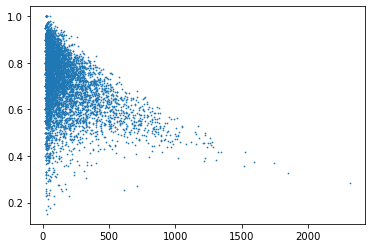

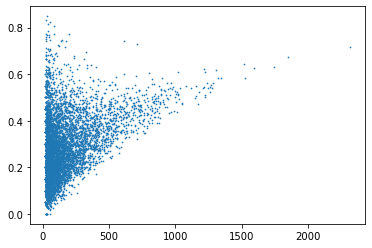

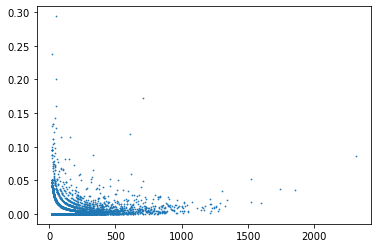

In [437]:
# ratio of pop and tail items for warm-/cold-start users
score_data['pop'] = score_data['movie_id'].apply(lambda x: 1 if x in pop_items else 0)
score_data['tail'] = score_data['movie_id'].apply(lambda x: 1 if x in tail_items else 0)
score_data['niche'] = score_data['movie_id'].apply(lambda x: 1 if x in niche_items else 0)

user_pop_cnt = score_data.groupby(['user_id'])['pop']
user_tail_cnt = score_data.groupby(['user_id'])['tail']
user_niche_cnt = score_data.groupby(['user_id'])['niche']

plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_pop_cnt.sum()/user_pop_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_tail_cnt.sum()/user_tail_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_niche_cnt.sum()/user_niche_cnt.count(), s=0.5) # 비율 
plt.show()

In [438]:
np.random.seed(seed)
warm_user_test = np.random.choice(warm_users, int(len(warm_users)*0.25), replace=False)
warm_user_train = np.setdiff1d(warm_users, warm_user_test)

In [439]:
# new_user
cold_u_score = score_data[score_data['user_id'].apply(lambda x: True if x in cold_users else False)]
warm_u_score_train = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_train else False)]
warm_u_score_test = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_test else False)]

# no overlapping users
print(set(warm_u_score_train.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(cold_u_score.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(warm_u_score_train.index.values).intersection(set(cold_u_score.index.values)))

set()
set()
set()


In [440]:
print(len(warm_u_score_test.user_id.unique()))
print(len(warm_u_score_train.user_id.unique()))
print(len(cold_u_score.user_id.unique()))

1208
3624
1208


In [441]:
import json
with open('warm_state.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('warm_state_y.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).rating.apply(list).to_dict(), f)

with open('warm_state_popularity.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['popularity']).rating.apply(list).to_dict(), f)
    
with open('user_old_state.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).movie_id.apply(list).to_dict(), f)

with open('user_old_state_y.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_old_state_popularity.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['popularity']).rating.apply(list).to_dict(), f)
    
with open('user_cold_state.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('user_cold_state_y.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_cold_state_popularity.json', 'w') as f:
    json.dump(cold_u_score.groupby(['popularity']).rating.apply(list).to_dict(), f)

In [523]:
global_popularity = global_popularity/global_popularity.max()
with open('global_popularity.json', 'w') as f:
    json.dump(global_popularity.to_dict(), f)

In [529]:
global_popularity.min()

0.0002917152858809802

# Evaluation 

In [11]:
import torch
from typing import NoReturn, List, Dict
def evaluate_method(predictions: np.ndarray, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param topk: top-K values list
    :param metrics: metrics string list
    :return: a result dict, the keys are metrics@topk
    """
    evaluations = dict()
    sort_idx = (-predictions).argsort(axis=1)
    gt_rank = np.argwhere(sort_idx == 0)[:, 1] + 1
    #print(gt_rank.shape)
    for k in topk:
        hit = (gt_rank <= k)
        for metric in metrics:
            key = '{}@{}'.format(metric, k)
            if metric == 'HR':
                evaluations[key] = hit.mean().astype(np.float16)
            elif metric == 'NDCG':
                evaluations[key] = (hit / np.log2(gt_rank + 1)).mean().astype(np.float16)
            else:
                raise ValueError('Undefined evaluation metric: {}.'.format(metric))
    evaluations['n_items'] = gt_rank.shape
    return evaluations

def item_ratio(predictions: np.ndarray, item_idx: np.ndarray, anchor_list: np.array, topk: list=[10, 20, 50, 100]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    evaluations = dict()
    item_idx = item_idx.reshape(predictions.shape)
    sort_idx = (-predictions).argsort(axis=1)
    for k in topk:
        evaluations['top_'+str(k)] = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], anchor_list).mean(axis=-1).mean()
    return evaluations

def evaluate_method_items(predictions: torch.tensor, anchor_list:list, item_idx:torch.tensor, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    item_pos = item_idx.view(-1,100)[:,0].numpy()
    total_items, pop_items, tail_items, niche_items = anchor_list
    predictions = predictions.view(-1,100).numpy()
    item_idx = item_idx.numpy()
    
    pred_pop = predictions[np.isin(item_pos, pop_items)]
    pred_tail = predictions[np.isin(item_pos, tail_items)]
    pred_niche = predictions[np.isin(item_pos, niche_items)]
    
    eval_total = evaluate_method(predictions)
    eval_pop = evaluate_method(pred_pop)
    eval_tail = evaluate_method(pred_tail)
    eval_niche = evaluate_method(pred_niche)
    
    ratio_total = item_ratio(predictions, item_idx, total_items)
    ratio_pop = item_ratio(predictions, item_idx, pop_items)
    ratio_tail = item_ratio(predictions, item_idx, tail_items)
    ratio_niche = item_ratio(predictions, item_idx, niche_items)
    
    df = pd.DataFrame(columns={**eval_total, **ratio_total}.keys())
    df = df.append(pd.DataFrame([{**eval_total, **ratio_total}], index=['total']))
    df = df.append(pd.DataFrame([{**eval_pop, **ratio_pop}], index=['pop']))
    df = df.append(pd.DataFrame([{**eval_tail, **ratio_tail}], index=['tail']))
    df = df.append(pd.DataFrame([{**eval_niche, **ratio_niche}], index=['niche']))
    
    
    return df


In [12]:
test_ways = ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = list(range(1,6))

In [13]:
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'preds', test_way, str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', test_way, str(seed_tmp), '.pt']))
        tmp_df = evaluate_method_items(predictions, anchor_list=anchor_list, item_idx=item_idx)
        tmp_df['seed'] = seed_tmp
        tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
        tmp_df['test_way'] = test_way[:-5]
        tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
        tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
        total_df = total_df.append(tmp_df.set_index('index'))

In [14]:
total_df

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,type,test_way,type_
index,,,,,,,,,,,,,,,
10_old_user_1_total,0.367188,0.252686,0.532715,0.305908,0.726562,0.354980,"(12080,)",0.997873,0.997384,0.994740,0.952311,1,total,10_old,10_old_total
10_old_user_1_pop,0.488281,0.339600,0.675293,0.400146,0.857422,0.446289,"(8523,)",0.686813,0.548932,0.317493,0.169980,1,pop,10_old,10_old_pop
10_old_user_1_tail,0.077026,0.044037,0.190918,0.080383,0.413330,0.135986,"(3557,)",0.311060,0.448452,0.677247,0.782331,1,tail,10_old,10_old_tail
10_old_user_1_niche,0.017548,0.008774,0.070190,0.026810,0.105286,0.035278,"(57,)",0.011738,0.016759,0.041848,0.199862,1,niche,10_old,10_old_niche
20_old_user_1_total,0.407227,0.280762,0.578125,0.335938,0.760742,0.382080,"(12080,)",0.999412,0.999102,0.996331,0.952320,1,total,20_old,20_old_total
20_old_user_1_pop,0.539062,0.376953,0.730469,0.439209,0.896973,0.481445,"(8544,)",0.721068,0.572993,0.323674,0.169892,1,pop,20_old,20_old_pop
20_old_user_1_tail,0.089355,0.048492,0.209839,0.086670,0.431396,0.141968,"(3536,)",0.278344,0.426109,0.672657,0.782429,1,tail,20_old,20_old_tail
20_old_user_1_niche,0.000000,0.000000,0.044769,0.014786,0.104492,0.029617,"(67,)",0.004470,0.009052,0.033897,0.199897,1,niche,20_old,20_old_niche
old_user_1_total,0.443848,0.308350,0.616211,0.364014,0.787109,0.407227,"(12080,)",0.999619,0.999425,0.997763,0.952450,1,total,old,old_total


In [15]:
df_mean = total_df.groupby(['test_way', 'type']).mean().drop(['seed'], axis=1)

In [16]:
[True for col in df_mean.columns if 'top' in col]

[True, True, True, True]

       10_old_top_10  20_old_top_10  old_top_10
type                                           
niche       0.003416       0.001680    0.000949
pop         0.740661       0.763464    0.800838
tail        0.258866       0.236409    0.199079
total       0.999526       0.999873    0.999917
       10_old_top_20  20_old_top_20  old_top_20
type                                           
niche       0.006663       0.004296    0.002484
pop         0.584863       0.603168    0.631763
tail        0.414435       0.396573    0.368080
total       0.999299       0.999741    0.999844
       10_old_top_50  20_old_top_50  old_top_50
type                                           
niche       0.029991       0.025004    0.018755
pop         0.326429       0.330180    0.333817
tail        0.670732       0.667781    0.665052
total       0.997161       0.997962    0.998869
       10_old_top_100  20_old_top_100  old_top_100
type                                              
niche        0.199712        0.199

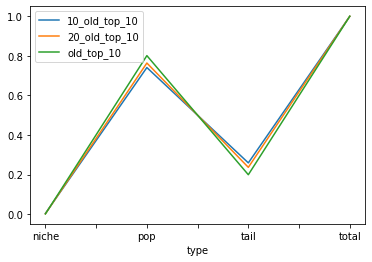

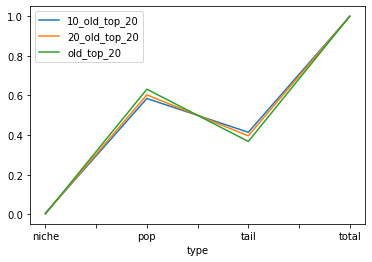

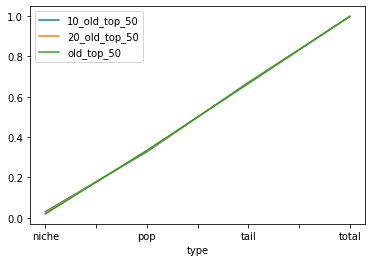

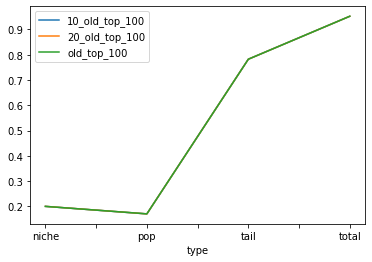

In [17]:
ratio_cols = df_mean.columns[[True if 'top' in col else False for col in df_mean.columns]]
ax = None
for metric in ratio_cols:
    a = df_mean[metric].unstack(level=0)
    a.columns = ['_'.join([column, metric]) for column in a.columns]
    print(a)
    ax = a.plot(ax=None)
    


# Correlation between history size and popularity bias

In [18]:
item_idx.shape

torch.Size([1208, 10, 100])

In [19]:
old_user = warm_u_score_test.groupby(['user_id']).movie_id.apply(list)
old_user_hist_len = warm_u_score_test.groupby(['user_id']).movie_id.count()

In [20]:
old_user_hist_len.values

array([129, 211,  70, ...,  48, 147,  60])

In [25]:
def plot_ratio(old_user_hist_len, pop_ratio, k):
    plt.scatter(old_user_hist_len, pop_ratio, s=5)
    plt.xlabel("history length")
    plt.ylabel("pop item recommendation ratio")
    plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
    plt.show()

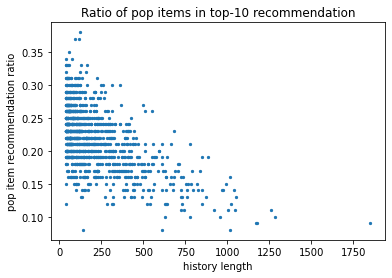

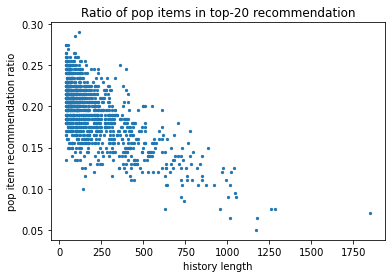

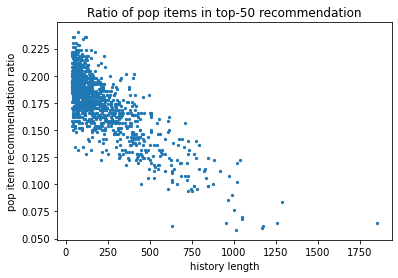

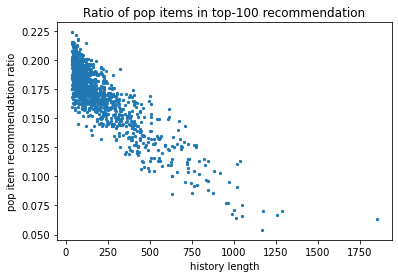

In [27]:
evaluations = dict()
item_idx = item_idx.reshape(predictions.shape)
sort_idx = (-predictions).argsort(axis=1)
for k in [10, 20, 50, 100]:    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    ax = plot_ratio(old_user_hist_len, pop_ratio, k)
    evaluations['top_'+str(k)] = pop_ratio

In [30]:
pop_ratio =  np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)

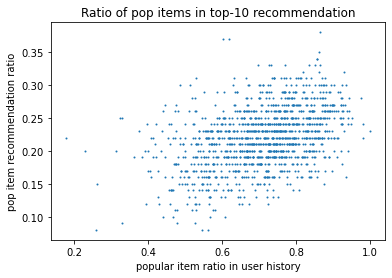

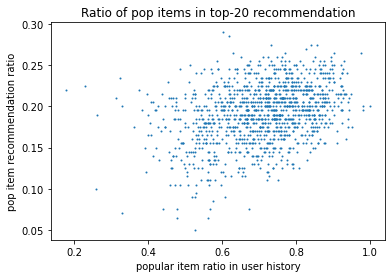

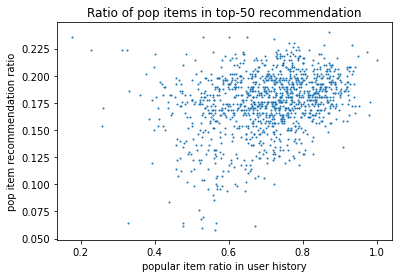

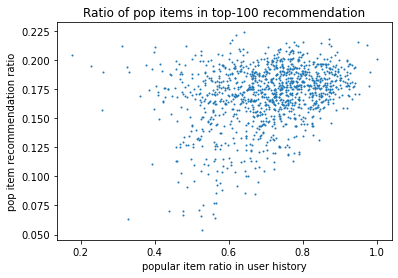

In [34]:
evaluations = dict()
item_idx = item_idx.reshape(predictions.shape)
sort_idx = (-predictions).argsort(axis=1)
for k in [10, 20, 50, 100]:    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    #ax = plot_ratio(old_user_hist_len, pop_ratio, k)
    evaluations['top_'+str(k)] = pop_ratio
    
    plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
    plt.xlabel("popular item ratio in user history")
    plt.ylabel("pop item recommendation ratio")
    plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
    plt.show()

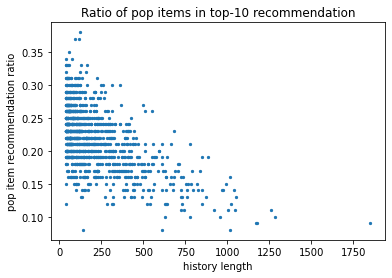

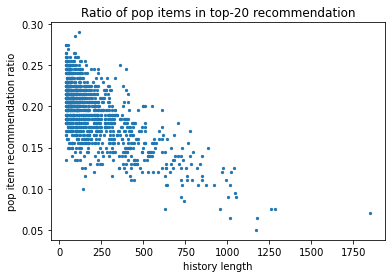

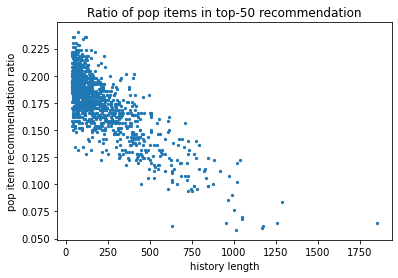

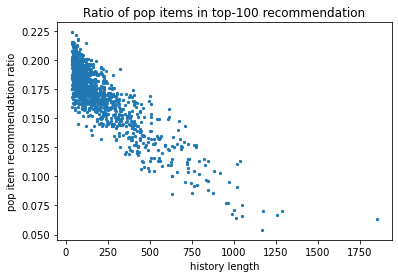

In [35]:
evaluations = dict()
item_idx = item_idx.reshape(predictions.shape)
sort_idx = (-predictions).argsort(axis=1)
for k in [10, 20, 50, 100]:    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    ax = plot_ratio(old_user_hist_len, pop_ratio, k)
    evaluations['top_'+str(k)] = pop_ratio

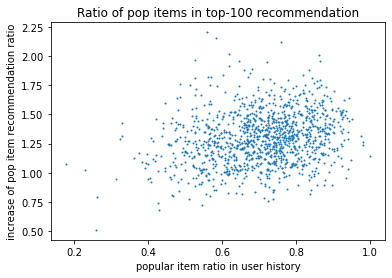

In [45]:
plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], evaluations['top_10']/evaluations['top_100'], s=1)
plt.xlabel("popular item ratio in user history")
plt.ylabel("increase of pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

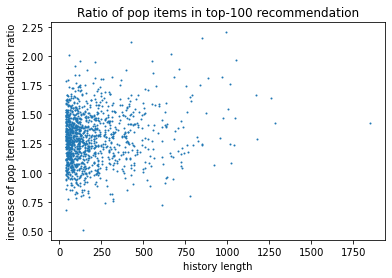

In [46]:
plt.scatter(old_user_hist_len, evaluations['top_10']/evaluations['top_100'], s=1)
plt.xlabel("history length")
plt.ylabel("increase of pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

# recommendation of popular items (of all items)

In [336]:
import os
#os.listdir('../../eval_result/')

In [236]:
import copy
def get_mask_index(data_df):
    '''Get user-item interaction index pair.'''
    tmp_df = copy.deepcopy(data_df[['user_id', 'movie_id']])
    uids = sorted(tmp_df['user_id'].unique())
    user2id = dict(zip(uids, range(len(uids))))
    tmp_df['user_id'] = tmp_df['user_id'].apply(lambda x: user2id[x])
    ui_pairs = tmp_df[['user_id', 'movie_id']].values
    return ui_pairs

def convert_item_to_index(ui_pairs, item_idx):
    assert (item_idx == item_idx[0]).all().item() # Check all the item indices are the same!
    item2id = dict(zip(item_idx[0].numpy(), range(len(item_idx[0])))) 

    # sanity check
    sanity_item = ui_pairs[0][1] # if user used item 1357
    # get the item's index in prediction via item2id
    assert sanity_item == item_idx[:, item2id[sanity_item]][0] # access the value obtained from item's index
    
    ui_pairs[:, 1] = np.array([item2id[item] for item in ui_pairs[:, 1]])
    return ui_pairs

In [371]:
try: int(test_way[:2])
except Exception as e:
    print(e)

invalid literal for int() with base 10: 'ol'


In [363]:
#ui_pairs = get_mask_index(warm_u_score_test)

sups = torch.load('_'.join(['../../eval_result/', 'total_sup', 'old_user', str(seed_tmp), '.pt']))

ui_pairs = []
for u_idx, u_sup in enumerate(sups):
    for sup in u_sup:
        ui_pairs.append([u_idx, sup])

ui_pairs = np.array(ui_pairs)
ui_pairs = convert_item_to_index(ui_pairs, item_idx)

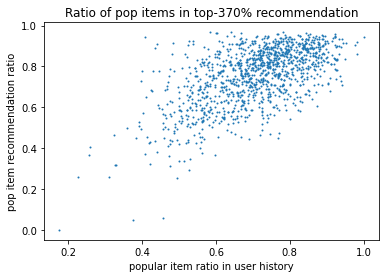

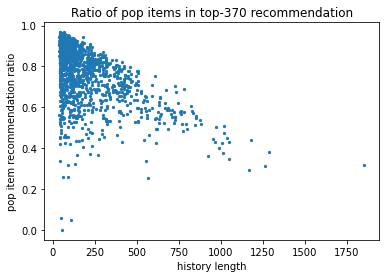

In [593]:
test_ways = ['old_user']# ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = [1]
masking = True
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df_all = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        #predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way, str(seed_tmp), '.pt']))
        #item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way, str(seed_tmp), '.pt']))
        evaluations = dict()
        #break
        # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
        if masking:
            predictions[ui_pairs.transpose()] = float('-inf')
        
        
        # [user, item] prediction 결과를 sorting하고
        # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
        #topk = [10, 20, 50, 100, 500]
        #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
        topk = [int(0.5*len(pop_items))]
        
        sort_idx = (-predictions).argsort(axis=1)
        item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
            evaluations['top_'+str(k)] = pop_ratio
        
            plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
            plt.xlabel("popular item ratio in user history")
            plt.ylabel("pop item recommendation ratio")
            plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
            plt.show()
            
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
            plot_ratio(old_user_hist_len, pop_ratio, k)
        break
    break

In [594]:
(user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()]

user_id
2       0.813953
17      0.720379
27      0.757143
28      0.794393
31      0.621849
          ...   
6014    0.669811
6018    0.817610
6022    0.895833
6023    0.680272
6033    0.866667
Name: pop, Length: 1208, dtype: float64

In [620]:
(user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values]

user_id
32      0.812500
54      0.800000
85      0.615385
91      0.772727
115     0.736842
          ...   
5864    0.871795
5933    0.878049
5965    0.657895
5970    0.822222
6022    0.895833
Name: pop, Length: 135, dtype: float64

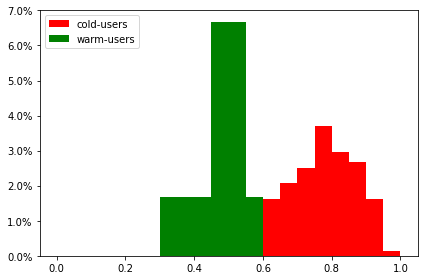

In [635]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], color='red' , bins=20, density=True, range=(0,1), label='cold-users')
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], color='green', bins=20, density=True, range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

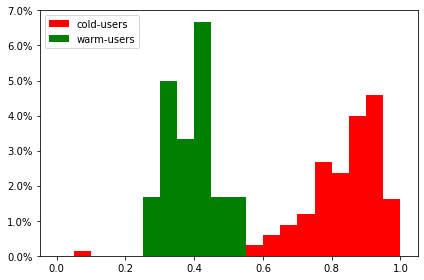

In [632]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

# PD

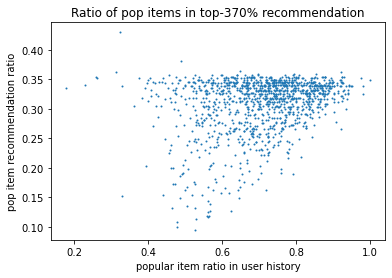

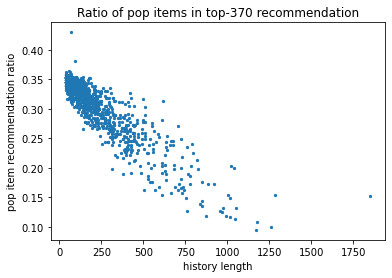

In [638]:
test_ways = ['old_user']# ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = [2]
masking = True
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df_all = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+'PD', str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way+'PD', str(seed_tmp), '.pt']))
        evaluations = dict()
        #break
        # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
        if masking:
            predictions[ui_pairs.transpose()] = float('-inf')
        
        
        # [user, item] prediction 결과를 sorting하고
        # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
        #topk = [10, 20, 50, 100, 500]
        #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
        topk = [int(0.5*len(pop_items))]
        
        sort_idx = (-predictions).argsort(axis=1)
        item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
            evaluations['top_'+str(k)] = pop_ratio
        
            plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
            plt.xlabel("popular item ratio in user history")
            plt.ylabel("pop item recommendation ratio")
            plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
            plt.show()
            
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
            plot_ratio(old_user_hist_len, pop_ratio, k)
        break
    break

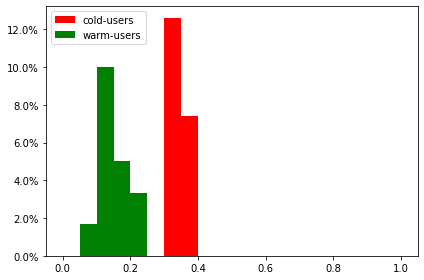

In [639]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

# PDA

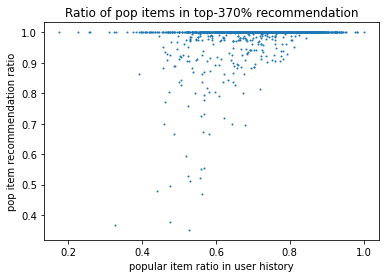

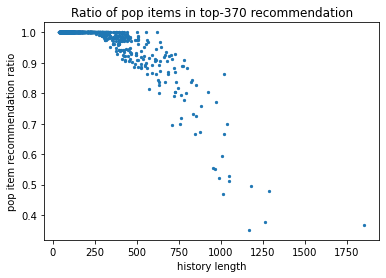

In [662]:
topk = [int(0.5*len(pop_items))]

predictions_ = predictions*(torch.tensor(global_popularity[item_idx[0].numpy()].values)**0.1)
sort_idx = (-predictions_).argsort(axis=1)
item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
for k in topk:
    pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
    evaluations['top_'+str(k)] = pop_ratio

    plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
    plt.xlabel("popular item ratio in user history")
    plt.ylabel("pop item recommendation ratio")
    plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
    plt.show()

for k in topk:
    pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
    plot_ratio(old_user_hist_len, pop_ratio, k)

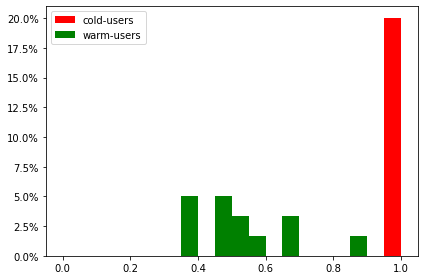

In [663]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

In [641]:
a = np.array([[10, 30, 20], 
              [60, 40, 50]])
np.sort(a, axis=1) # array([[10, 20, 30],
                   #        [40, 50, 60]])
ai = np.argsort(a, axis=1); ai # array([[0, 2, 1],
                               #        [1, 2, 0]])
    
np.take_along_axis(a, ai, axis=1) # array([[10, 20, 30],
                                  #        [40, 50, 60]])

array([[10, 20, 30],
       [40, 50, 60]])

# Genre-wise comparison

# distribution of prediction: normalized prediction scores of top 100 users and bottom 100 users

In [ ]:
warm_u_score_test.groupby(['user_id']).count()['movie_id'].sort_values()[100:]

user_id
923       46
5665      46
5741      47
2770      47
3480      47
        ... 
5367    1169
1088    1176
1980    1260
1015    1286
1680    1850
Name: movie_id, Length: 1108, dtype: int64

In [ ]:
cold_u_score.groupby(['user_id']).count()['movie_id'].sort_values()

user_id
6038    20
3407    20
1664    20
3530    20
341     20
        ..
2360    37
740     37
5756    38
1973    38
681     38
Name: movie_id, Length: 1208, dtype: int64

In [ ]:
density

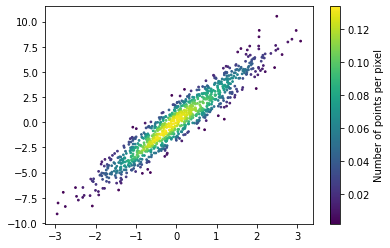

In [533]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
density = ax.scatter(x, y, c=z, s=3)
fig.colorbar(density, label='Number of points per pixel')
plt.show()

In [547]:
cold_u_score

,user_id,movie_id,rating,timestamp,pop,tail,niche,popularity
233,4,3468,5,978294008,1,0,0,0.000450
234,4,1210,3,978293924,1,0,0,0.002882
235,4,2951,4,978294282,1,0,0,0.000522
236,4,1214,4,978294260,1,0,0,0.002024
237,4,1036,4,978294282,1,0,0,0.001666
...,...,...,...,...,...,...,...,...
999740,6038,1387,2,956707005,1,0,0,0.001697
999741,6038,2700,1,956715051,1,0,0,0.001269
999742,6038,2716,3,956707604,1,0,0,0.002181
999743,6038,3396,3,956706827,1,0,0,0.000744


In [548]:
user_pop_cnt.

In [ ]:
user_pop_cnt.sum()/user_pop_cnt.count()